# Tutorial 1: reading and preparing data for an HMP model

In this tutorial we will show you how to read data from :

1. Epoched data
1. Raw (preprocessed) EEG data in *.bdf* or *.fif* format
2. Data already transformed to PC space (e.g. previous applications of HMP)

All these methods assume that the data has been preprocessed (e.g. see method section of [this paper](https://psyarxiv.com/nmg6w/)  for an example of preprocessing for HMP), if you don't know where to start for preprocessing EEG, the [MNE](https://mne.tools/stable/index.html) is full of tutorials on EEG data.

## 1. Reading epoched preprocessed data

This section assumes that you have epoched data under a csv file format with columns time and epoch, and one column per electrode (see example under sample_data/ and [osf](https://osf.io/aq74y) for an example of how to generate those using mne)

For this section we will rely on data that can be found in the ```sample_data/``` folder. This data was collected for [this](https://www.sciencedirect.com/science/article/pii/S1053811914002249) paper and fitted using HMP in [this](https://link.springer.com/article/10.1007/s42113-021-00105-2) paper. I downloaded and preprocessed (see preprocessing notebooks in ```sample_data/eeg/```) the data that can be found on the [OSF project](https://osf.io/pd3kf/) of the former paper.

First we start by locating the data and creating a list with all participant names/number

In [2]:
import os 
import numpy as np 
import pandas as pd
import xarray as xr
import hsmm_mvpy as hmp

eeg_data_path = os.path.join('sample_data/eeg/')#Declaring path where the eeg data is
subj_names = [x.split('.')[0] for x in os.listdir(eeg_data_path) if 'csv' in x]#Extracting subject name based on the file name
print(subj_names)

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


['0025', '0024', '0023', '0022']


Then, because _hmp_ relies on reaction times (RT) defined EEG trials only, we need to cut the epoched data into their duration in terms of RT. The problem is that most software and packages dealing with EEG usually discard the infos about the RTs (except if working with metadata as with [mne epochs](https://mne.tools/stable/auto_tutorials/epochs/30_epochs_metadata.html)) so we need to use the behavioral data that was co-registered. 

If ever you only have the raw EEG data but you have stimulus and response trigger you can move to section 2 where we build _hmp_ compatible data from raw _bdf_ or _fif_ files.

In [3]:
behavioral_data_path = os.path.join('sample_data/behavior/')#Declaring path where the eeg data is

data_group = []#Where to store participants data

for participant in subj_names:#for loop for each participant in the experiment
    print(participant)#keeping track
    #First we read the behavioral data, the name of the colums is at the end of the next line and will depend on your experiment
    behavior = pd.read_csv(os.path.join(behavioral_data_path+'%s-cnv-sat3_ET.csv'%participant), sep=';')[['stim', 'resp', 'RT','cue', 'movement',]]
    #Next we need to store the infos of the RT and experimental conditions for each recorded epochs
    #(optional) we can rename the varaiable that are numerically coded, this does make your code more transparent for others
    behavior['movement'] = behavior.apply(lambda row: 'stim_left' if row['movement'] == -1 else 
                                      ('stim_right' if row['movement'] == 1 else np.nan), axis=1)
    behavior['resp'] = behavior.apply(lambda row: 'resp_left' if row['resp'] == 1 else 
                                      ('resp_right' if row['resp'] == 2 else np.nan ), axis=1)
    #Merging together the exeperimental conditions info to have the format condition/stimulus/response
    behavior['trigger'] = behavior['cue'] + '/' +  behavior['movement'] + '/' +  behavior['resp']
    
    #Next if you want some RTs not to be analyzed (e.g. less than 300 ms because unrealistically fast) you should do this by zeroing out outliers RTs
    behavior['RT'] = behavior.apply(lambda row: 0 if row['RT'] < 300 else (
                0 if row['RT'] > 3000 else row['RT']), axis = 1)
    
    #Then we read the associated EEG data 
    data = pd.read_csv(eeg_data_path+participant+'.csv', index_col=0).reset_index(drop=True)
    #Drop any column that is not time, epoch or electrode name
    data = data.drop(columns='condition')
    #For this specific data we need to rename FP1 and FP2 to align to montage convention
    data = data.rename(columns={'FP1':'Fp1', 'FP2':'Fp2'})
    #And use the integrated function in hmp to cut off the epochs to the duration of RTs and declare at which sampling frequency the data is
    data_group.append(hmp.utils.parsing_epoched_eeg(data=data, rts=behavior['RT'], conditions=behavior['trigger'],  sfreq=100))

#Store all this into an xarray file with new 'participant' dimentsion
epoch_data = xr.concat(data_group, pd.Series(subj_names, name="participant"),
                  fill_value={'event':'', 'data':np.nan})

0025
Totaling 178 valid trials
0024
Totaling 183 valid trials
0023
Totaling 193 valid trials
0022
Totaling 182 valid trials


This is then the data ready to be used with hmp instances

In [4]:
epoch_data

<xarray.Dataset>
Dimensions:      (epochs: 200, electrodes: 30, samples: 210, participant: 4)
Coordinates:
  * epochs       (epochs) int64 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
  * electrodes   (electrodes) <U3 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 203 204 205 206 207 208 209
  * participant  (participant) object '0025' '0024' '0023' '0022'
Data variables:
    data         (participant, epochs, electrodes, samples) float64 2.891e+06...
    event        (participant, epochs) object 'SP/stim_right/resp_left' ... '...
Attributes:
    sfreq:    100
    offset:   0

Let's save the data for use in the next tutorials:

In [5]:
epoch_data.to_netcdf('sample_data/sample_data.nc')

# 2. Reading raw data

For the following I give an example using (yet not public) preprocessed EEG data that has not yet been epoched. This section is useful if you:
- Do not have the behavioral data to use RTs and associated conditions
- Need additional triggers in the EEG data (e.g., feedback)

__Nota bene__: the 'raw' data is assumed to be preprocessed for artifacts and eye-related activity

First in order for the HMP to run on each trial we have to declare the stimulus triggers as well as the response triggers which defines a trial. 
In the case of this data, the stimulus trigger is a 3 digit code where the first digit codes for the condition (speed or accuracy), the second for the side of the stimulus correct answer and the third one to the stimulus difficulty level. The response trigger codes either left responses or right responses. These triggers will then be used as info for the specific condition of the trial as well as its reaction time (i.e. the time between the stimulus trigger onset and the response trigger onset)

(see Chapter 5 of https://thesiscommons.org/342zp if you want more details on the data and the design)

In [6]:
stimulus_id = {'accuracy/left/1':211,'accuracy/left/2':212,'accuracy/left/3':213,
           'accuracy/right/1':221,'accuracy/right/2':222,'accuracy/right/3':223,
            'speed/left/1':111,'speed/left/2':112,'speed/left/3':113, #conditions in the experiment
           'speed/right/1':121,'speed/right/2':122,'speed/right/3':123} # used for segmentation
resp_id = {'r_left':100,'r_right':200}#Response events

Then we specify wich files we want to analyse, if for example you have all your participant dat inside one folder you can do the following :

In [7]:
import os
eeg_path = os.path.join('../../../PHD/ForceEEG_2021/processing_EEG/preprocessed_data/')#Where the raw EEG data is relative to where you run the code on your computer
subj_names = [x.split('_')[1].split('.')[0] for x in os.listdir(eeg_path) if 'preprocessed' in x]#select files which contain the string 'preprocessed'
subj_names = subj_names[:2]#Take the two first participant for the illustration
subj_files = [eeg_path+ 'preprocessed_'+x+'_raw.fif' for x in subj_names]#Create a list of files that can be read from the folder

Next we can directly use the ```subj_file``` list and feed it to the ```hmp.utils.read_mne_EEG``` but first you have to decide on a number of parameters regarding EEG processing, see the following helper of the function

In [8]:
from hsmm_mvpy import utils
utils.read_mne_EEG?

Signature:
utils.read_mne_EEG(
    pfiles,
    event_id,
    resp_id,
    sfreq=None,
    subj_idx=None,
    events_provided=None,
    verbose=True,
    tmin=-0.2,
    tmax=5,
    offset_after_resp=0,
    high_pass=0.5,
    pick_channels='eeg',
    baseline=(None, 0),
    low_pass=30,
    upper_limit_RT=5,
    lower_limit_RT=0.001,
    reject_threshold=None,
)
Docstring:
Reads EEG data format (.fif or .bdf) using MNE's integrated function .

Notes: 
- Only EEG data are selected (other channel types are discarded)
- All times are expressed on the second scale.
- If multiple files in pfiles the data of the group is read and seqentially processed.
- Reaction Times are only computed if response trigger is in the epoch window (determined by tmin and tmax)

Procedure:
1) the data is filtered with filters specified in low_pass and high_pass. Parameters of the filter are
    determined by MNE's filter function.
2) if no events is provided, detect events in stumulus channel and keep events with

This is then an example call to the function based on previous _hmp_ applications

In [9]:
import hsmm_mvpy as hmp
sfreq = 100 #at what sampling rate we want the data, downsampling to 100Hz is computationally less intensive for hmp instances
tmin, tmax = -.25, 2 #window size for the epochs, from 250ms before the stimulus up to 2 seconds after, data will be baseline corrected from tmin to 0
offset_after_resp = .05 #The epochs will be cropped to each epochs RTs, but we want to keep a few ms after the response in case some events are later (very optional)
high_pass, low_pass = .5,  30 #The filtering bandwidth, parameters of the filters are defined automatically by MNE
lower_limit_RT, upper_limit_RT = .25, 2 #lower and upper limit for the RTs all values outside of this range are discarded

mne_data = hmp.utils.read_mne_EEG(subj_files, stimulus_id, resp_id, sfreq, subj_idx=subj_names, tmin=tmin, tmax=tmax, offset_after_resp=offset_after_resp, 
                            high_pass=high_pass, low_pass =low_pass, lower_limit_RT=lower_limit_RT, upper_limit_RT=upper_limit_RT, 
                            verbose=False)#Turning verbose off for the documentation but it is recommended to leave it on as some output from MNE might be useful

Processing participant ../../../PHD/ForceEEG_2021/processing_EEG/preprocessed_data/preprocessed_S10_raw.fif
Correcting event values as trigger channel has offset [768]
Reading 0 ... 4814847  =      0.000 ...  4701.999 secs...
Downsampling to 100 Hz
Creating epochs based on following event ID :[100 111 112 113 121 122 123 200 211 212 213 221 222 223]
N trials without response event: 0
Applying reaction time trim to keep RTs between 0.25 and 2 seconds
2269 RTs kept of 2294 clean epochs
2269 trials were retained for participant ../../../PHD/ForceEEG_2021/processing_EEG/preprocessed_data/preprocessed_S10_raw.fif
End sampling frequency is 100 Hz
Processing participant ../../../PHD/ForceEEG_2021/processing_EEG/preprocessed_data/preprocessed_S18_raw.fif
Correcting event values as trigger channel has offset [768]
Reading 0 ... 5106687  =      0.000 ...  4986.999 secs...
Downsampling to 100 Hz
Creating epochs based on following event ID :[100 111 112 113 121 122 123 200 211 212 213 221 222 223]

This is then the data ready to be used with hmp instances

In [10]:
mne_data

<xarray.Dataset>
Dimensions:      (epochs: 2419, electrodes: 64, samples: 191, participant: 2)
Coordinates:
  * epochs       (epochs) int64 0 1 2 3 4 5 6 ... 2435 2436 2437 2438 2439 2440
  * electrodes   (electrodes) <U3 'Fp1' 'AF7' 'AF3' 'F1' ... 'PO8' 'PO4' 'O2'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 184 185 186 187 188 189 190
  * participant  (participant) <U3 'S10' 'S18'
Data variables:
    data         (participant, epochs, electrodes, samples) float64 1.139e-05...
    event        (participant, epochs) <U16 'accuracy/right/3' ... 'speed/lef...
Attributes:
    sfreq:    100.0
    offset:   5

# 3. Data already transformed to PC space (e.g. previous applications of HMP MVPA)


This part is addressed mainly for researchers wanting to replicate previous findings with matlab with data that has already been turned into principal component space and contains therefore __very specific code__ that most users will probably not need.

For this example we will use the data from the study by Anderson, Zhang, Borst, & Walsh ([2016](https://psycnet.apa.org/doi/10.1037/rev0000030)) that you can download here: http://www.ai.rug.nl/~jpborst/modelbasedneuro/analysis_data_model.zip

__IMPORTANT__: if you want to run this part of the notebook you need to download the [data](http://www.ai.rug.nl/~jpborst/modelbasedneuro/analysis_data_model.zip) and put the files ```analysis_data_model/data/varForevents135_100.mat```  and ```analysis_data_model/analysis/HSMM_code/chanlocs.mat``` in the same folder as the notebook.

First we read the .mat data file using ```scipy```

In [12]:
import scipy.io
import numpy as np

mat = scipy.io.loadmat('varForBumps135_100.mat')#Where the .mat file with all the data and necessary infos is
data = np.array(mat['normedscore10'])# The data in PC space
starts = np.array(mat['x'][:,0]) -1#correcting to be 0 indexed
ends = np.array(mat['y'][:,0])-1#correcting to be 0 indexed
subjects = np.array(mat['subjects'])-1 #correcting to be 0 indexed

Here we will adapt the structure of the matlab data to the expected data format

In [13]:
### Recovering RTs, trials and participants
durations = ends - starts + 1
limits = np.cumsum(durations)
limits = np.concatenate([[0],limits])
participant, trials = np.unique(subjects, return_counts=True)


# creating data watrix with participant x trial x max duration x electrodes/comp
unstacked_data = np.tile(np.nan, (len(participant), np.max(trials), np.shape(data)[1], np.max(durations)))
conditions = np.tile(np.nan, (len(participant), np.max(trials)))
for trial in np.arange(len(durations)):
    if trial > 0 and subjects[trial] == subjects[trial-1]:
        within_trial += 1
    else:
        within_trial = 0
    unstacked_data[subjects[trial], within_trial, :,:durations[trial],] = data[limits[trial]:limits[trial+1]].T
    conditions[subjects[trial], within_trial] = mat['conds'][trial]

unstacked_data = hmp.utils.hmp_data_format(unstacked_data, conditions, sfreq=100, participants=participant)#converting to xarray
unstacked_data = unstacked_data.rename({'electrodes':'component'})#Data is already on PC space so no need to use the transform function
unstacked_data.to_netcdf('unstacked_data.nc')#saving the converted data

In [14]:
unstacked_data

<xarray.Dataset>
Dimensions:      (participant: 20, epochs: 789, component: 10, samples: 300)
Coordinates:
  * participant  (participant) uint8 0 1 2 3 4 5 6 7 ... 12 13 14 15 16 17 18 19
  * epochs       (epochs) int64 0 1 2 3 4 5 6 7 ... 782 783 784 785 786 787 788
  * component    (component) int64 0 1 2 3 4 5 6 7 8 9
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 293 294 295 296 297 298 299
Data variables:
    data         (participant, epochs, component, samples) float64 2.294 ... nan
    event        (participant, epochs) float64 1.0 1.0 2.0 1.0 ... nan nan nan
Attributes:
    sfreq:    100
    offset:   0

Now the data is in the expected format for HMP however we still need to recover the electrodes position

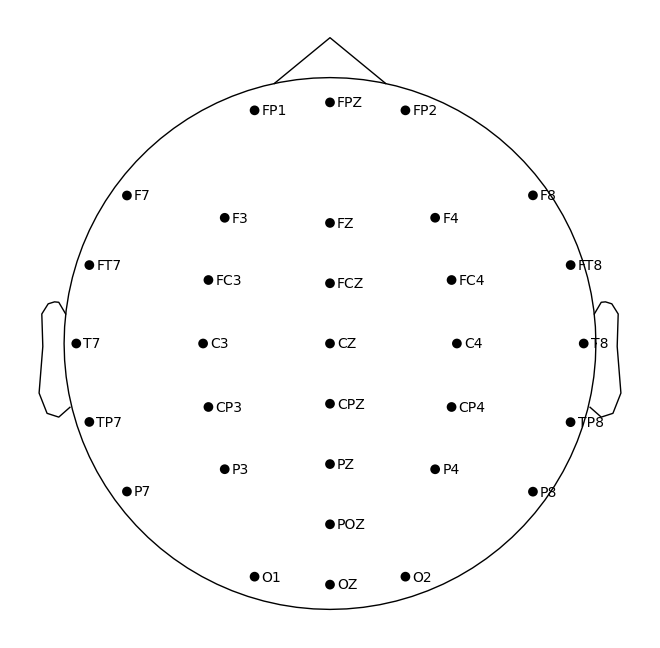

In [15]:
channels_loc = scipy.io.loadmat('chanlocs.mat')#Channel location 
positions_dict_i =  [{str(electrode[0][0]):[-electrode[5][0][0]/1000,electrode[4][0][0]/1000,electrode[6][0][0]/1000]} 
                     for electrode in channels_loc['chanlocs'][0]]#Dictionnary with x,y,z positions
positions_dict = {}
for i in positions_dict_i:
     positions_dict.update(i)
        
from mne import channels#

montage = channels.make_dig_montage(positions_dict,coord_frame='head')
positions = np.array([x[-1][:2] for x in np.array(list(montage.get_positions()['ch_pos'].items()),dtype=object)[:,:]])
names = np.array([x[0] for x in np.array(list(montage.get_positions()['ch_pos'].items()),dtype=object)[:,:]])
montage.plot();
np.save('positions',positions)#saving the positions

Everything is now ready to be used in _hmp_

In [16]:
stacked_data = hmp.utils.stack_data(unstacked_data.data)
init = hmp.models.hmp(stacked_data, sfreq=100, event_width=50, cpus=4)

Here is an example to run and plot a 5 event model once it is uncommented:

In [ ]:
# model = init.fit_single(5) 
# mean_event_times_selected = init.event_times(model.eventprobs.dropna('event'))
# electrodes_selected = xr.DataArray(hsmm.utils.reconstruct(model.magnitudes.T, mat['coeff10'][:,:10], 
#                             mat['latent10'][:10], np.mean(mat['data'],axis=0)))
# hsmm.visu.plot_topo_timecourse(electrodes_selected, mean_event_times_selected, positions, 
#                                init, magnify=1, figsize=(12,1),
#                                 time_step = 1000/init.sfreq,  times_to_display = np.mean(ends - starts),
#                                 ylabels='5 events model', vmin=-10, vmax=10)